In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import KMeans
from time import time
from sklearn import metrics
from sklearn.metrics.cluster import contingency_matrix, homogeneity_score, completeness_score, adjusted_rand_score, adjusted_mutual_info_score, v_measure_score
from sklearn.metrics.cluster import contingency_matrix

In [3]:
ratings_df = pd.read_csv('Synthetic_Movie_Lens/ratings.csv')  
print('Columns of ratings_df: {0}'.format(ratings_df.columns))

Columns of ratings_df: Index(['Unnamed: 0', 'userId', 'movieId', 'rating', 'timestamp'], dtype='object')


In [4]:
#movies df (tidy data)
movies_df = pd.read_csv('Synthetic_Movie_Lens/movies.csv')
print('Columns of movies_df: {0}'.format(movies_df.columns))

Columns of movies_df: Index(['movieId', 'title', 'genres'], dtype='object')


In [24]:
movies_df['genres'].nunique()

951

In [36]:
from surprise import BaselineOnly
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise.model_selection import train_test_split
from surprise import NMF
from surprise.accuracy import rmse
import pickle

In [6]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

In [7]:
def get_top_n(predictions, userId, movies_df, ratings_df, n = 10):
    '''Return the top N (default) movieId for a user,.i.e. userID and history for comparisom
    Args:
    Returns: 
  
    '''
    
    #1. First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    #2. Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key = lambda x: x[1], reverse = True)
        top_n[uid] = user_ratings[: n ]
    
    #Part II.: inspired by: https://beckernick.github.io/matrix-factorization-recommender/
    
    #3. Tells how many movies the user has already rated
    user_data = ratings_df[ratings_df.userId == (userId)]
    print('User {0} has already rated {1} movies.'.format(userId, user_data.shape[0]))

    
    #4. Data Frame with predictions. 
    preds_df = pd.DataFrame([(id, pair[0],pair[1]) for id, row in top_n.items() for pair in row],
                        columns=["userId" ,"movieId","rat_pred"])
    
    
    #5. Return pred_usr, i.e. top N recommended movies with (merged) titles and genres. 
    pred_usr = preds_df[preds_df["userId"] == (userId)].merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId')
            
    #6. Return hist_usr, i.e. top N historically rated movies with (merged) titles and genres for holistic evaluation
    hist_usr = ratings_df[ratings_df.userId == (userId) ].sort_values("rating", ascending = False).merge\
    (movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId')
       
    return hist_usr, pred_usr
    

## NMF Collaborative Filter 

In [8]:
trainset = data.build_full_trainset()
testset = trainset.build_anti_testset()


In [16]:
algo_NMF = NMF(n_factors = 16)
algo_NMF.fit(trainset)

# Predict ratings for all pairs (u, i) that are NOT in the training set.
predictions = algo_NMF.test(testset)

In [31]:
hist_NMF_124, pred_NMF_124 = get_top_n(predictions, movies_df = movies_df, userId = 124, ratings_df = ratings_df)

User 124 has already rated 50 movies.


### Sweep

In [15]:
sweep_k = np.arange(2,50,2) # number of latent factors

In [36]:

number_of_folds = 10
results_rmse = []
results_mae = []

# kf = KFold(n_splits=number_of_folds)
# results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)

for k in sweep_k:
    algorithm = NMF(n_factors = k)
    results = cross_validate(algorithm, data, measures=['rmse', 'mae'], cv=10)
    results_rmse.append(results['test_rmse'].mean())
    results_mae.append(results['test_mae'].mean())

In [ ]:
def  trim_test_set():
    return df

In [37]:

pickle.dump( results_rmse, open( "result_nmf_all_rmse.pkl", "wb" ) )
pickle.dump( results_mae, open( "result_nmf_all_mae.pkl", "wb" ) )

In [13]:
with open('result_nmf_all_mae.pkl', 'rb') as f:
    result_nmf_all_mae = pickle.load(f)

with open('result_nmf_all_rmse.pkl', 'rb') as f:
    result_nmf_all_rmse = pickle.load(f)

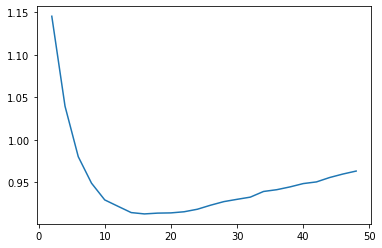

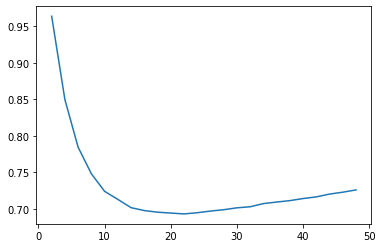

In [16]:

plt.plot(sweep_k, np.array(result_nmf_all_rmse))
plt.show()
plt.plot(sweep_k, np.array(result_nmf_all_mae))

In [22]:
best_latent_factor_nmf_all_rmse = sweep_k[np.argmin(result_nmf_all_rmse)]
best_latent_factor_nmf_all_mae = sweep_k[np.argmin(result_nmf_all_mae)]
print("Optimal number of latent factors for NMF via RMSE Error {} and MAE error {}".format(best_latent_factor_nmf_all_rmse,best_latent_factor_nmf_all_mae))

Optimal number of latent factors for NMF via RMSE Error 16 and MAE error 22


No, the number of movie genres if 951 but the optimal latent factors are 16 or 22 here

## ROC curves

In [47]:
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline

In [59]:
thresholds = [2.5, 3, 3.5, 4]
algo_rmse = NMF(n_factors = best_latent_factor_nmf_all_rmse)
algo_mae = NMF(n_factors = best_latent_factor_nmf_all_mae)
trainset, testset = train_test_split(data, test_size=0.1,shuffle=True)
algo_rmse.fit(trainset)
algo_mae.fit(trainset)
predictions_rmse = algo.test(testset)
predictions_mae = algo.test(testset)

In [ ]:
get_roc_params(predictions ,thresholds)

In [58]:
def get_roc_params(predictions ,thresholds):
    true_ratings = [getattr(pred, 'r_ui') for pred in predictions]
    estimated_rating = [getattr(pred, 'est') for pred in predictions]
    fpr = {}
    tpr = {}
    threshs = {}
    for i, thresh in enumerate(thresholds):
        true_ratings_bins = [1 if r > thresh else 0 for r in true_ratings]
        threshs[i] = thresh
        fpr[i], tpr[i], _ = metrics.roc_curve(true_ratings_bins, estimated_rating)
        plot_roc(fpr[i], tpr[i], thresh)
    return fpr, tpr, t

def plot_roc(fpr, tpr, thresh, file_name=None):
    fig, ax = plt.subplots()
    roc_auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=2, color = 'r', label='Area Under Curve (AUC) = {}'.format(roc_auc))
    ax.grid(color='0.7', linestyle='--', linewidth=0.8)

    ax.set_xlabel('False Positive Rate', size=15)
    ax.set_ylabel('True Positive Rate', size=15)
    ax.legend(loc="lower right")
    plt.title('Threshold  = {}'.format(thresh), size=15)
    plt.show()
     

## Trimmed Test Sets

In [27]:
min_movie_ratings = 2 #a movie has was rated at least 
min_user_ratings =  5 # has atleast these many ratings
min_var = 2

popular_df = ratings_df.groupby("movieId").filter(lambda x: x['rating'].count() > min_movie_ratings)
unpopular_df =  ratings_df.groupby("movieId").filter(lambda x: x['rating'].count() <= min_movie_ratings)
high_variance_df =  ratings_df.groupby("movieId").filter(lambda x: x['rating'].var() < min_var and x['rating'].count() > min_user_ratings)
# ratings_flrd_df = ratings_flrd_df.groupby("userId").filter(lambda x: x['userId'].count() >= min_user_ratings)

In [33]:
high_variance_df.groupby("movieId").apply(print)

        Unnamed: 0  userId  movieId  rating   timestamp
255            255     448        1     5.0  1019126661
1006          1006      91        1     4.0  1112713037
1126          1126     353        1     5.0   831939685
2967          2967     504        1     4.0  1063644695
3399          3399      50        1     3.0  1514238116
...            ...     ...      ...     ...         ...
98235        98235     112        1     3.0  1442535639
99059        99059     337        1     4.0   860255715
100059      100059      15        1     2.5  1510577970
100209      100209      45        1     4.0   951170182
100668      100668      90        1     3.0   856353996

[215 rows x 5 columns]
        Unnamed: 0  userId  movieId  rating   timestamp
148            148     512        2     3.0   841449636
657            657     122        2     4.0  1461561176
2589          2589     484        2     2.5  1342296219
3528          3528     232        2     4.0  1085351710
5242          5242     2

""


In [25]:
ratings_df

,Unnamed: 0,userId,movieId,rating,timestamp
0,0,496,112852,3.0,1415520462
1,1,391,1947,4.0,1030945141
2,2,387,1562,1.5,1095041022
3,3,474,2716,4.5,1053020930
4,4,483,88125,4.5,1311337237
...,...,...,...,...,...
100831,100831,469,1219,4.0,965661925
100832,100832,599,3571,2.0,1498511343
100833,100833,414,276,3.0,961596299
100834,100834,395,168,3.0,841503984


In [ ]:
# define a cross-validation iterator
kf = KFold(n_splits=3)


for k in sweep_k:
    
    for trainset, testset in kf.split(data):
        algo = NMF(n_factors = k)
        
        # train and test algorithm.
        algo.fit(trainset)
        predictions = algo.test(testset)

        # Compute and print Root Mean Squared Error
        rmse(predictions, verbose=True)

In [ ]:
# – Train the collaborative filter on the train set
# – Write a trimming function that takes as input the test set and outputs a trimmed test set
# – Predict the ratings of the movies in the trimmed test set using the trained collaborative filter
# – Compute the RMSE of the predictions in the trimmed test set

